# Simple implementation of MNIST by Hugo


In [7]:
import torch
from torch import nn
import torch.nn.functional as F
from torchvision import datasets, transforms  # Consists datasets, model architectures, image transformations for computer vision
from torch import optim

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt

import helper    # Not a standard library but one created by Udacity

## Load the data
Here we'll use the MNIST dataset which consists of greyscale handwritten digits. Each image is 28x28 pixels. We only need the train dataset for this example.
* Definine a transform function which converts the PIL data to tensors and does some normalization. Normalization requires mean and standard deviation. Each is a tuple with values for each channel. Our image has only one channel therefore it is (0.5,)
* Dowload the dataset and do the transformation. The first argument is where you want to store the data, download=True means that we want to save the data locally, train=True means download the training set and not the testingset
* Convert into an dataloader. The batch size is the number of images we get in one iteration from the data loader and pass through our network, often called a batch. And shuffle=True tells it to shuffle the dataset every time we start going through the data loader again. 

[intro to MNIST](https://nextjournal.com/gkoehler/pytorch-mnist)

[intro to dataloader](https://towardsdatascience.com/pytorch-basics-intro-to-dataloaders-and-loss-functions-868e86450047)

In [2]:
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5,), (0.5,)),
                              ])
trainset = datasets.MNIST('~/.pytorch/MNIST_data/', download=True, train=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

## Checking the data
Looking at the data we got in a few different ways. 
* trainloader is a special type of object
* trainiter is now a iterable object 
* Shape has 64 rows which is consistent with the batch size. Then for the image we see that we have 1 channel and 28X28 pixels
* imshow() takes the 2nd image, converts it from PIL to numpy array. squeeze() removes the extra array parathesis [[x]] to [x]. cmap is the color map.

trainloader is a:	<torch.utils.data.dataloader.DataLoader object at 0x0000021528710A88> of size 938
dataiter is a:		<class 'torch.utils.data.dataloader._SingleProcessDataLoaderIter'> of size 938
images is a: <class 'torch.Tensor'> and labels is a: <class 'torch.Tensor'>
Shape of image: torch.Size([64, 1, 28, 28]) and labels: torch.Size([64])


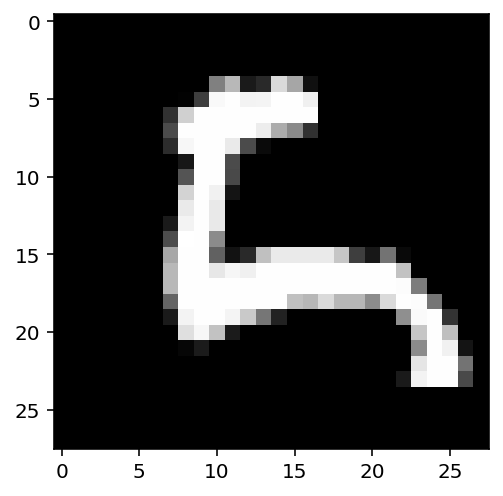

In [27]:
dataiter = iter(trainloader)       # iter() function returns an iterator for the given object
images, labels = dataiter.next()   # Grabing one batch from iterator
print(f"trainloader is a:\t{trainloader} of size {len(trainloader)}")
print(f"dataiter is a:\t\t{type(dataiter)} of size {len(dataiter)}")
print(f"images is a: {type(images)} and labels is a: {type(labels)}")
print(f"Shape of image: {images.shape} and labels: {labels.shape}")

plt.imshow(images[1].numpy().squeeze(), cmap='Greys_r');

## Building the model
We can now shift our attention to buiding the model using nn.Sequential. It takes a list of a transformation). We are assuming that we will get a vector input with 784 inputs (28*28) then via two hidden layers reduce it to the 10 outputs. The size of the hidden layer is chosen from experience but the 1st one is 128 and the 2nd one is 64. The activation functions is also chosen from experience in this case we chose ReLU for the 1st hidden layer than LogSoftmax.

It i more convenient to build the model with a log-softmax output using nn.LogSoftmax. Then you can get the actual probabilities by taking the exponential torch.exp(output). With a log-softmax output, you want to use the negative log likelihood loss, nn.NLLLoss. 

As an optimizer we use the Schotastic Gradient descent. It will be the object that will keep track of the gradients that need to be re- zeroed.

In [14]:
model = nn.Sequential(nn.Linear(784, 128),
                      nn.ReLU(),
                      nn.Linear(128, 64),
                      nn.ReLU(),
                      nn.Linear(64, 10),
                      nn.LogSoftmax(dim=1))

criterion = nn.NLLLoss()
optimizer = optim.SGD(model.parameters(), lr=0.003)

## Training the model
Will perform a number of iteration across all the 938 images. In e

[loss.item()](https://discuss.pytorch.org/t/what-is-loss-item/61218)

In [18]:
epochs = 5
for _ in range(epochs):
    running_loss = 0
  
    for images, labels in trainloader:              # It will iterate 938 times since that is size of trainloader
        images = images.view(images.shape[0], -1)   # Flatten MNIST images into a 784 long vector
    
        optimizer.zero_grad()                       # Reset the gradients during each epoch
        outputs = model.forward(images)             # Run the forward pass of the model
        loss = criterion(outputs, labels)           # Question: why are log probability in same unit as labels?
        loss.backward()                             # Run the back-propagation pass of with the gradient
        optimizer.step()                            # Update the parameters
        
        running_loss += loss.item()                 # .item() is returns a scalar/float of the loss the image

    else:
        print(f"Training loss: {running_loss/len(trainloader)}")

Training loss: 0.36014693388457236 938
Training loss: 0.3411630002547429 938
Training loss: 0.3264919398451792 938
Training loss: 0.3149353564420997 938
Training loss: 0.3050193067457376 938


# Testing the model
Download a new image which should be flatten. 

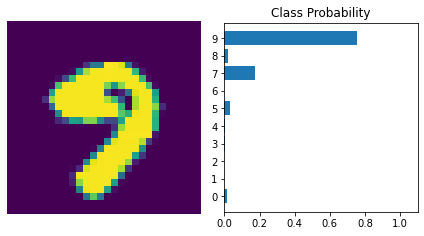

In [5]:
images, labels = next(iter(trainloader))        # Get a new batch of images from the loader
img = images[0].view(1, 784)                    # flatten

with torch.no_grad():                           # Turn off gradients to speed up this part
    logps = model(img)                          # Run the model, need to take exponential of the values to get probabilities 

# Output of the network are log-probabilities, need to take exponential for probabilities
ps = torch.exp(logps)
helper.view_classify(img.view(1, 28, 28), ps)   # Using Udacity module to print results